In [1]:
#Following the tutorial from https://github.com/python-engineer/tensorflow-course/blob/master/08_09_Star_Wars_Project.ipynb

import os
import math
import random
import shutil
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load data
BASE_DIR = 'lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

In [3]:
model_resnet50 = keras.models.Sequential()
model_resnet50.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg')) # We add the pooling to make the dimension comparable
model_resnet50.add(layers.Dense(5))
model_resnet50.layers[0].trainable = False
model_resnet50.summary()

2022-10-28 10:20:16.785839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-28 10:20:16.785973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [4]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

# Set up our models
model_resnet50.compile(optimizer=optim, loss=loss, metrics=metrics)

In [5]:
# get the preprocessing function of this model // The same funtion works for ResNet
#preprocess_input = tf.keras.applications.vgg16.preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [6]:
# Fit the model

epochs = 30
early_stopping2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)

# Train the ResNet50 model
print('*************TRAINING THE RESNET MODEL*************')
history_resnet50 = model_resnet50.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping2],
          epochs=epochs, verbose=2)

*************TRAINING THE RESNET MODEL*************
Epoch 1/30


2022-10-28 10:20:24.694225: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-28 10:20:25.561938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 10:20:26.864826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 3s - loss: 2.0663 - accuracy: 0.2973 - val_loss: 1.0584 - val_accuracy: 0.6250 - 3s/epoch - 274ms/step
Epoch 2/30
10/10 - 1s - loss: 0.6743 - accuracy: 0.7027 - val_loss: 0.6257 - val_accuracy: 0.8750 - 666ms/epoch - 67ms/step
Epoch 3/30
10/10 - 1s - loss: 0.2508 - accuracy: 0.9459 - val_loss: 0.6623 - val_accuracy: 0.7500 - 672ms/epoch - 67ms/step
Epoch 4/30
10/10 - 1s - loss: 0.0957 - accuracy: 1.0000 - val_loss: 0.4731 - val_accuracy: 0.8750 - 680ms/epoch - 68ms/step
Epoch 5/30
10/10 - 1s - loss: 0.0491 - accuracy: 1.0000 - val_loss: 0.4638 - val_accuracy: 0.9375 - 684ms/epoch - 68ms/step
Epoch 6/30
10/10 - 1s - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.4632 - val_accuracy: 0.8750 - 688ms/epoch - 69ms/step
Epoch 7/30
10/10 - 1s - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.4633 - val_accuracy: 0.8750 - 678ms/epoch - 68ms/step
Epoch 8/30
10/10 - 1s - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.8750 - 651ms/epoch - 65ms/step
Epoch 9/30
10/10 - 1s

In [7]:
model_resnet50.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 0.0919 - accuracy: 1.0000 - 432ms/epoch - 144ms/step


[0.09193824976682663, 1.0]

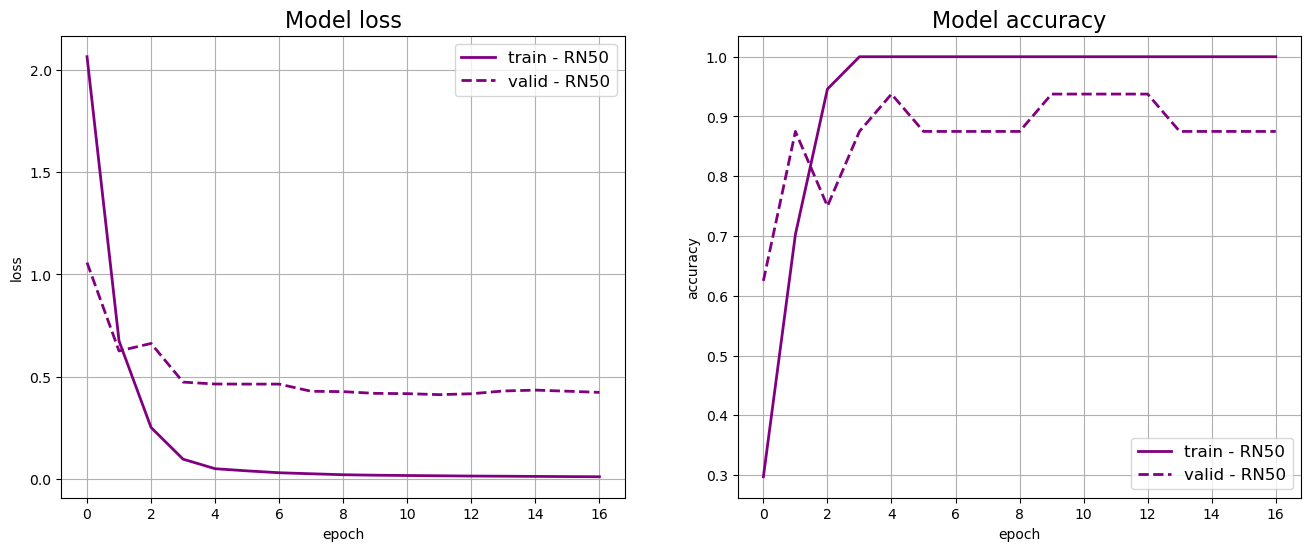

In [8]:
# Plots for loss and acc
from turtle import color


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['loss'], label='train - RN50', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_resnet50.history['val_loss'], label='valid - RN50', color = 'purple', linestyle='--',
        linewidth=2)
#plt.plot(history_resnet50.history['loss'], label='train - RN50', color = 'darkturquoise', linestyle='-',
#        linewidth=2)
#plt.plot(history_resnet50.history['val_loss'], label='valid - RN50', color = 'darkturquoise', linestyle='--',
#        linewidth=2)
plt.title('Model loss', fontdict={'size': 16})  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'], label='train - RN50', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_resnet50.history['val_accuracy'], label='valid - RN50', color = 'purple', linestyle='--',
        linewidth=2)
#plt.plot(history_resnet50.history['accuracy'], label='train - RN50', color = 'darkturquoise', linestyle='-',
#        linewidth=2)
#plt.plot(history_resnet50.history['val_accuracy'], label='valid - RN50', color = 'darkturquoise', linestyle='--',
#        linewidth=2)
plt.title('Model accuracy',fontdict={'size': 16})  
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.grid()
plt.legend(fontsize=12)